In [37]:
import pandas as pd
import numpy as np
import re

#Sentiment analysis
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# spacy for lemmatization
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 300
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## 1- Sentiment analysis of french and US tweets per vaccine:

In [123]:
# merging files
tweets_fr = pd.read_csv('../data/tweets_fr_translated.csv')
tweets_us_north = pd.read_csv('../data/tweets_us_north-clean.csv')
tweets_us_south = pd.read_csv('../data/tweets_us_south_clean.csv')

### 1- Perform sentiment analysis classification by using pretrained model “distilbert-base-uncased-finetuned-sst-2-english” (default classifier from 🤗):

In [124]:
classifier = pipeline('sentiment-analysis')

In [125]:
tweets_fr["sen_ana"] = tweets_fr["translated_text"].apply(classifier)

In [126]:
tweets_us_north["sen_ana"] = tweets_us_north["text"].apply(classifier)
tweets_us_south["sen_ana"] = tweets_us_south["text"].apply(classifier)

### 2- Split result into two columns:

In [127]:
def split_label(lb):
    label = re.findall(r"[A-Z]+", lb)[0]
    return label

In [128]:
def split_score(sc):
    score = re.findall(r"\d+\.\d+", sc)[0]
    return score   

In [129]:
tweets_fr["score"] = tweets_fr["sen_ana"].apply(str).apply(split_score)
tweets_fr["label"] = tweets_fr["sen_ana"].apply(str).apply(split_label)

In [130]:
tweets_us_north["score"] = tweets_us_north["sen_ana"].apply(str).apply(split_score)
tweets_us_north["label"] = tweets_us_north["sen_ana"].apply(str).apply(split_label)

In [131]:
tweets_us_south["score"] = tweets_us_south["sen_ana"].apply(str).apply(split_score)
tweets_us_south["label"] = tweets_us_south["sen_ana"].apply(str).apply(split_label)

In [132]:
# Change column score from object to float
tweets_fr['score'] = tweets_fr['score'].astype('float64')
tweets_us_north['score'] = tweets_us_north['score'].astype('float64')
tweets_us_south['score'] = tweets_us_south['score'].astype('float64')

**Save files:**

In [133]:
tweets_fr.to_csv('../data/tweet_fr_sa.csv', index=False)
tweets_us_north.to_csv('../data/tweets_us_north_sa.csv', index=False)
tweets_us_south.to_csv('../data/tweets_us_south_sa.csv', index=False)

### 3- Bar plots:

In [134]:
tweets_fr_gp = tweets_fr.groupby(["vaccine", "label"])["score"].mean().reset_index()

In [135]:
fig = px.bar(tweets_fr_gp, x='vaccine', y='score', color ='label', barmode='group',title= 'Sentiments analysis of French tweets toward COVID-19 vaccines',
            labels={
                 "score": "Score",
                 "vaccine": "",
                 "label": "Sentiment"
             },
            color_discrete_map={ # replaces default color mapping by value
                "NEGATIVE": "#9467bd", "POSITIVE": "lightsalmon"
            },
                        category_orders={"vaccine": ["pfizer", "moderna","astrazeneca", "johnson"]
                        },
             template="simple_white"
            )
fig.update_yaxes(showgrid=True, showline=False, tickwidth=0, tickcolor='white')
fig.update_xaxes(showline=True, zeroline=True)
            
fig.show()

In [136]:
tweets_us_north_gp = tweets_us_north.groupby(["vaccine", "label"])["score"].mean().reset_index()

In [137]:
fig = px.bar(tweets_us_north_gp, x='vaccine', y='score', color ='label', barmode='group',title= 'Sentiments analysis of Northern US tweets toward COVID-19 vaccines',
            labels={
                 "score": "Score",
                 "vaccine": "",
                 "label": "Sentiment"
             },
            color_discrete_map={ # replaces default color mapping by value
                "NEGATIVE": "#9467bd", "POSITIVE": "lightsalmon"
            },
                        category_orders={"vaccine": ["pfizer", "moderna","astrazeneca", "johnson"]
                        },
             template="simple_white"
            )
fig.update_yaxes(showgrid=True, showline=False, tickwidth=0, tickcolor='white')
fig.update_xaxes(showline=True, zeroline=True)
            
fig.show()

In [138]:
tweets_us_south_gp = tweets_us_south.groupby(["vaccine", "label"])["score"].mean().reset_index()

In [139]:
fig = px.bar(tweets_us_south_gp, x='vaccine', y='score', color ='label', barmode='group',title= 'Sentiments analysis of Southern US tweets toward COVID-19 vaccines',
            labels={
                 "score": "Score",
                 "vaccine": "",
                 "label": "Sentiment"
             },
            color_discrete_map={ # replaces default color mapping by value
                "NEGATIVE": "#9467bd", "POSITIVE": "lightsalmon"
            },
                        category_orders={"vaccine": ["pfizer", "moderna","astrazeneca", "johnson"]
                        },
             template="simple_white"
            )
fig.update_yaxes(showgrid=True, showline=False, tickwidth=0, tickcolor='white')
fig.update_xaxes(showline=True, zeroline=True)
            
fig.show()

## 2- Word frequency:

In [140]:
custom_stopwords = STOPWORDS.union(set(['vaccine', 'covid','pfizer', 'astrazeneca', 'moderna', 'johnson', 'janssen']))

In [174]:
def word_frequency(df):
    word_vectorizer = TfidfVectorizer(
        ngram_range=(1,1),
        analyzer='word',
        stop_words=custom_stopwords
    )
    
    # Remove short words, pumctuation, numbers and special characters
    sparse_matrix = word_vectorizer.fit_transform(
        df["translated_text"].apply(lambda x: " ".join([x for x in simple_preprocess(x) if len(x)>3])
            )
        )
        
    
    # Create frequency matrix
    frequencies = sparse_matrix.sum(axis=0)
    
    # Create DF from frequency matrix
    result_df = pd.DataFrame(frequencies.reshape(-1,1), index=word_vectorizer.get_feature_names(), columns=['frequency'])
    
    # Return sorted DF
    return result_df    

In [175]:
#tweets_fr_janssen = tweets_fr[tweets_fr["vaccine"] == 'johnson']

In [176]:
freq_tweets_fr = word_frequency(tweets_fr)

In [177]:
freq_tweets_fr = freq_tweets_fr.reset_index()

In [178]:
freq_tweets_fr = freq_tweets_fr.rename(columns={'index':'words'})

In [179]:
tuples_fr = [tuple(x) for x in freq_tweets_fr.values]

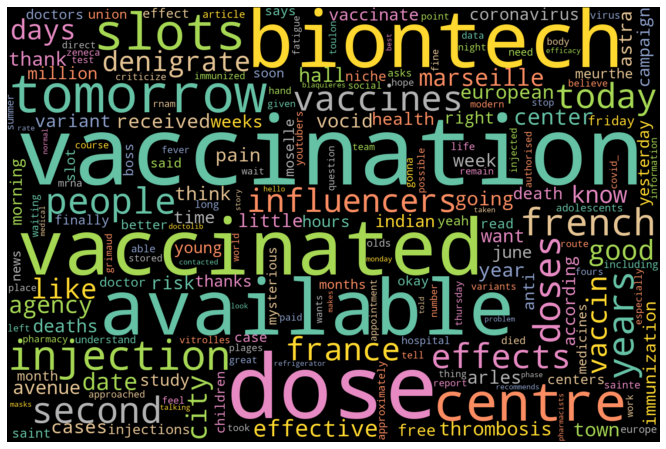

In [180]:
plt.figure(figsize= (12, 8))
wordcloud = WordCloud(width = 1500, height = 1000,
                      random_state=1, background_color='black', colormap='Set2',collocations=False).generate_from_frequencies(dict(tuples_fr))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [181]:
def word_frequency_us(df):
    word_vectorizer = TfidfVectorizer(
        ngram_range=(1,1),
        analyzer='word',
        stop_words=custom_stopwords
    )
    
    # Remove short words, pumctuation, numbers and special characters
    sparse_matrix = word_vectorizer.fit_transform(
        df["text"].apply(lambda x: " ".join([x for x in simple_preprocess(x) if len(x)>3])
            )
        )
        
    
    # Create frequency matrix
    frequencies = sparse_matrix.sum(axis=0)
    
    # Create DF from frequency matrix
    result_df = pd.DataFrame(frequencies.reshape(-1,1), index=word_vectorizer.get_feature_names(), columns=['frequency'])
    
    # Return sorted DF
    return result_df    

In [182]:
freq_tweets_us_north = word_frequency_us(tweets_us_north)
freq_tweets_us_south = word_frequency_us(tweets_us_south)

In [183]:
freq_tweets_us_north = freq_tweets_us_north.reset_index()
freq_tweets_us_south = freq_tweets_us_south.reset_index()

In [184]:
freq_tweets_us_north = freq_tweets_us_north.rename(columns={'index':'words'})
freq_tweets_us_south = freq_tweets_us_south.rename(columns={'index':'words'})

In [185]:
tuples_us_n = [tuple(x) for x in freq_tweets_us_north.values]
tuples_us_s = [tuple(x) for x in freq_tweets_us_south.values]

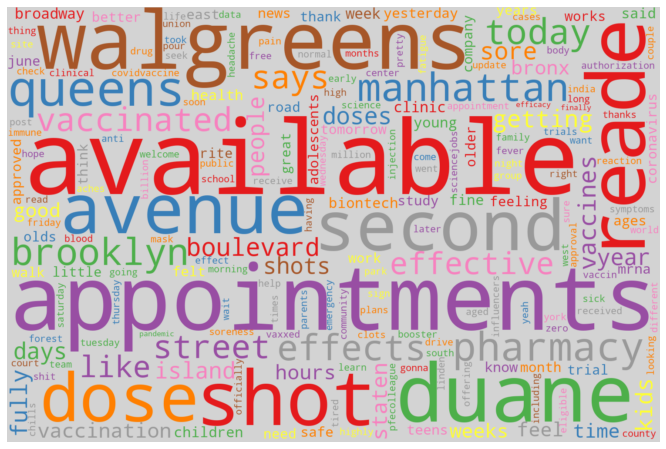

In [194]:
plt.figure(figsize= (12, 8))
wordcloud = WordCloud(width = 1500, height = 1000,
                      random_state=1, background_color='lightgray', colormap='Set1',collocations=False).generate_from_frequencies(dict(tuples_us_n))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

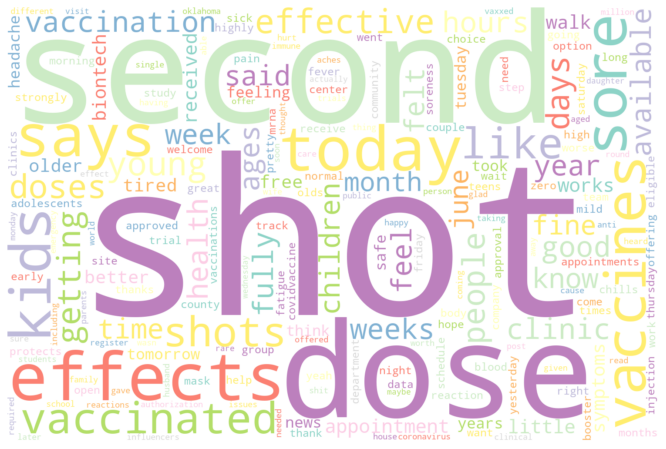

In [189]:
plt.figure(figsize= (12, 8))
wordcloud = WordCloud(width = 1500, height = 1000,
                      random_state=1, background_color='white', colormap='Set3',collocations=False).generate_from_frequencies(dict(tuples_us_s))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 3- Topic modeling - Latent Dirichlet Allocation (LDA):

In [40]:
custom_stopwords_lda = STOPWORDS.union(set(['vaccine', 'covid', 'pfizer', 'astrazeneca', 'moderna', 'johnson', 'janssen']))

In [93]:
test = tweets_fr[tweets_fr["vaccine"] == 'johnson']

In [95]:
test = test.drop(columns=["id", "date", "location", "follower_count", "retweets"])

In [116]:
test["text"] = test["text"].apply(lambda x: " ".join([x for x in simple_preprocess(x) if len(x)>3]))

In [119]:
# Convert to list
data = test.text.values.tolist()

In [121]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

[['live', 'meetup', 'dataprivacy', 'necessite', 'actions', 'differentes', 'rapport', 'anonymisation', 'selon', 'valerie', 'gabay', 'senior', 'manager', 'data', 'privacy', 'chez', 'johnson', 'johnson']]


In [122]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['live', 'meetup', 'dataprivacy', 'necessite', 'actions', 'differentes', 'rapport', 'anonymisation', 'selon', 'valerie', 'gabay', 'senior', 'manager', 'data', 'privacy', 'chez', 'johnson', 'johnson']


In [112]:
test

text  \
634                                                   live meetup dataprivacy nécessite actions différentes rapport anonymisation selon valérie gabay senior manager data privacy chez johnson johnson   
635    johnson johnson condamnée plusieurs fois pour avoir sous estimé risques surestimé bénéfices opioïdes participant ainsi crise opioïdes genre entreprise vous demande faire confiance aveuglément   
636                                                                                                                               jeune mère souffre hémorragie cérébrale après vaccin johnson johnson   
637                                                                                             quand souhaites faire vacciner mais choix entre alors johnson johnson disponibles pays cons acte scène   
638                                                                                                                                                                   vert pour vaccin johnson johnson   
...                                                                                                                                                                                                ...   
11947                        gouvernement belge interrompu vaccinations avec vaccin johnson johnson pour personnes moins après femme soit morte complication écrit standaard slovène âgée moins épouse   
11948                                                                                                                               covid belgique mort suspecte femme vaccinée vaccin johnson johnson   
11949                    direct coronavirus pression dans hôpitaux continue baisser avec moins malades covid hospitalisés moins réanimation belgique restreint vaccin johnson johnson plus coronavirus   
11950                                                                                                                  covid belgique restreint vaccin johnson johnson plus après décès jeune patiente   
11951                                                                                    belgique réserve plus âgés vaccin curieux réserver produits dangereux gens plus fragiles tout contre intuitif   

       vaccine  
634    johnson  
635    johnson  
636    johnson  
637    johnson  
638    johnson  
...        ...  
11947  johnson  
11948  johnson  
11949  johnson  
11950  johnson  
11951  johnson  

[475 rows x 2 columns]

In [104]:
test.head(10)

text  \
634                                                 live meetup dataprivacy nécessite actions différentes rapport anonymisation selon valérie gabay senior manager data privacy chez johnson johnson   
635  johnson johnson condamnée plusieurs fois pour avoir sous estimé risques surestimé bénéfices opioïdes participant ainsi crise opioïdes genre entreprise vous demande faire confiance aveuglément   
636                                                                                                                             jeune mère souffre hémorragie cérébrale après vaccin johnson johnson   
637                                                                                           quand souhaites faire vacciner mais choix entre alors johnson johnson disponibles pays cons acte scène   
638                                                                                                                                                                 vert pour vaccin johnson johnson   
639                                                                                                                                                                 johnson johnson maintenant aussi   
640                                                                                                                     covid ouvertures dimanche intentions investissements johnson johnson tribune   
641                                                                                                                                                                             plus japonais contre   
642                                                                                                       oula devinez faire vacciner mardi avec johnson johnson monodose belges inscrivez vous qvax   
643                                                                                                                     covid ouvertures dimanche intentions investissements johnson johnson tribune   

     vaccine  
634  johnson  
635  johnson  
636  johnson  
637  johnson  
638  johnson  
639  johnson  
640  johnson  
641  johnson  
642  johnson  
643  johnson